In [15]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import h5py

from util import utils as data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Add the prediction results dir
json_dir = './results/sparse_noise/permute_noise_0_40/bootstrap_var/beta_loss_1_beta_reg_10_beta_scale_10_change_lr/cp_train_40'
batch_json = os.path.join(json_dir, 'test_batch.json')
beta_json = os.path.join(json_dir, 'test_beta.json')
preds_json = os.path.join(json_dir, 'test_preds.json')
scores_json = os.path.join(json_dir, 'test_scores.json')

# Add the train or test Data h5
data_h5 = '../data/hdf5/sparse_noise/permute_noise_0_40.h5'

NUM_CLASSIFY = 10

batch = data_utils.read_json(batch_json)
beta = data_utils.read_json(beta_json)
beta = [b[0] for b in beta]
preds = data_utils.read_json(preds_json)
preds = [p[0] for p in preds]
scores = data_utils.read_json(scores_json)

# FLAGS
FLAGS_VISUALIZE_BETA = True
FLAGS_VISUALIZE_PREDS = True
FLAGS_VISUALIZE_PRED_PROB = True
FLAGS_VISUALIZE_PRED_PROB_NON_NOISY = True

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data_X, labels_y, noisy_y = None, None, None
test_data_X, test_labels_y = None, None
if data_h5 is not None and len(data_h5) > 0:
    data_h5f = h5py.File(data_h5, 'r')
    data_X = np.array(data_h5f['data'])
    labels_y = np.array(data_h5f['label'])
    if "noisy_label" in data_h5f.keys():
        noisy_y = np.array(data_h5f['noisy_label'])
    
    # test_data_X = np.array(data_h5f['test']['data'])
    # test_labels_y = np.array(data_h5f['test']['labels'])
    data_h5f.close()
    

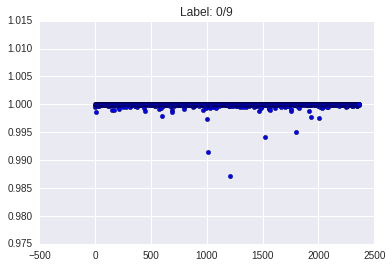

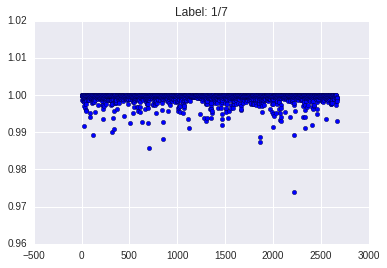

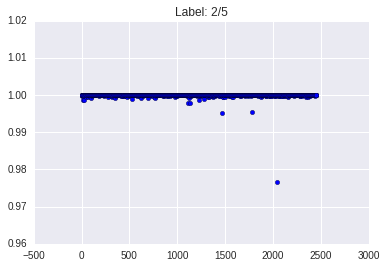

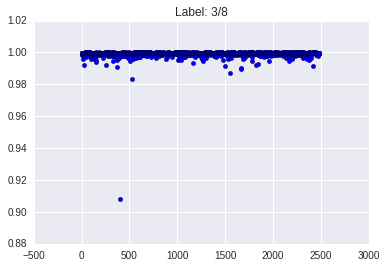

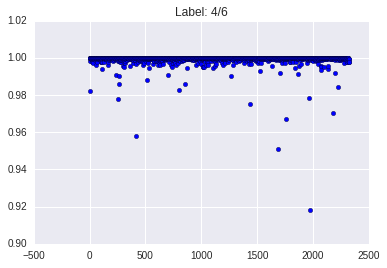

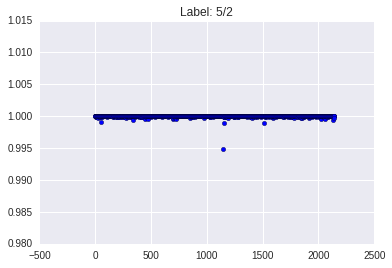

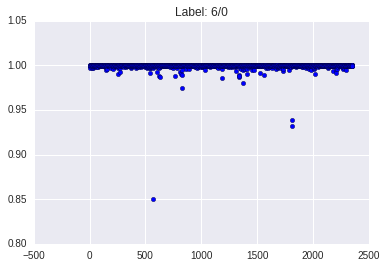

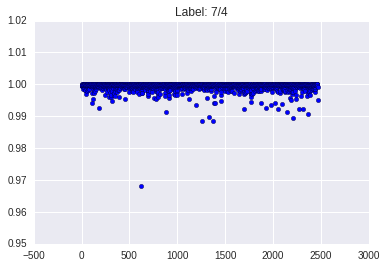

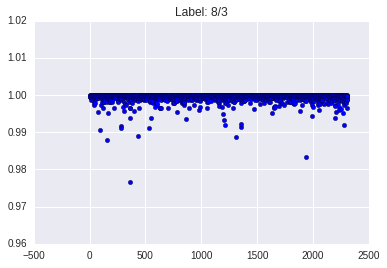

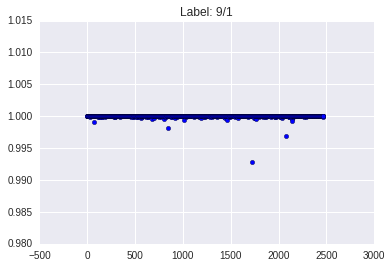

In [17]:
## Visualize the beta values being predicted by the model.
if FLAGS_VISUALIZE_BETA:
    beta_map = [[] for i in xrange(NUM_CLASSIFY)]
    noisy_beta_map = [[] for i in xrange(NUM_CLASSIFY)]
    for i in xrange(NUM_CLASSIFY): 
            noisy_beta_map[i] = [[] for _ in range(NUM_CLASSIFY)]
            
    for i in xrange(labels_y.shape[0]):
        org, noise = int(labels_y[i]), int(noisy_y[i])
        if org == noise:
            beta_map[org].append(beta[i])
        else:
            noisy_beta_map[org][noise].append(beta[i])
            
    '''
    for i, b in enumerate(beta_map):
        plt.scatter(range(len(b)), b)
        plt.title('Label: {}'.format(i))
        plt.show()
    '''    
    for i in xrange(len(noisy_beta_map)):
        for j in xrange(len(noisy_beta_map[i])):
            if len(noisy_beta_map[i][j]) > 500:
                plt.scatter(range(len(noisy_beta_map[i][j])), noisy_beta_map[i][j])
                plt.title('Label: {}/{}'.format(i, j))
                plt.show()

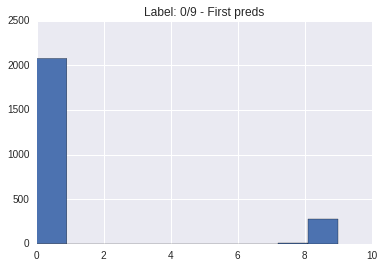

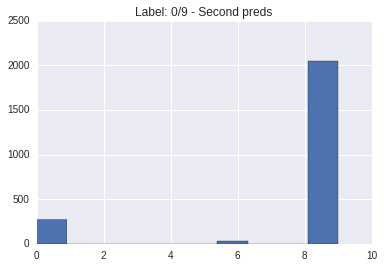

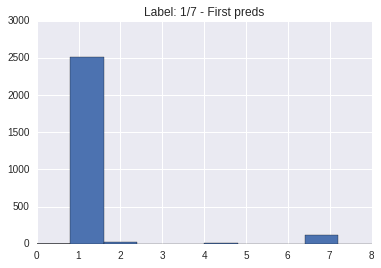

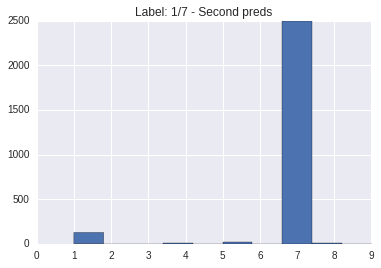

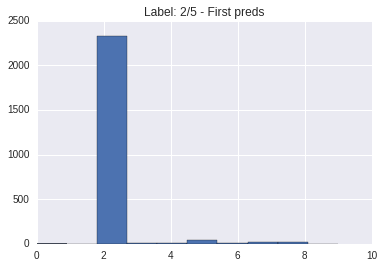

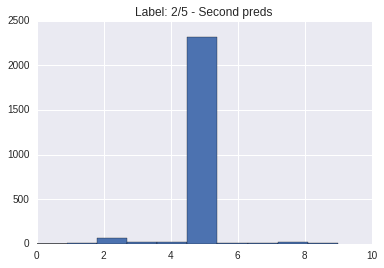

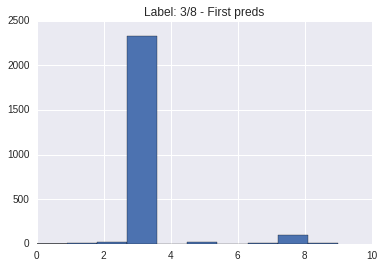

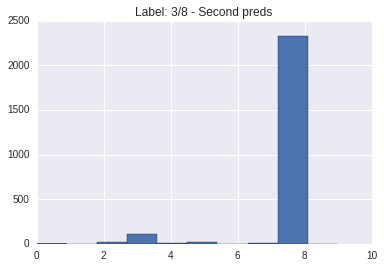

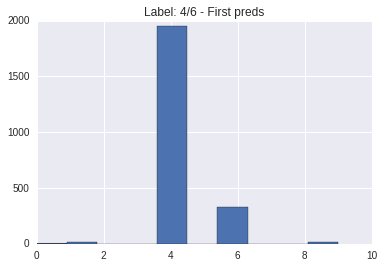

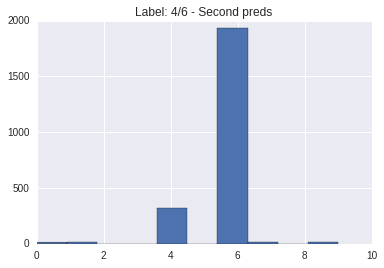

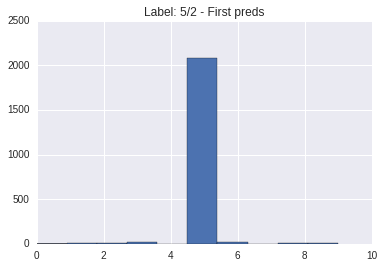

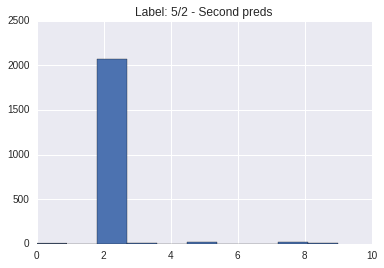

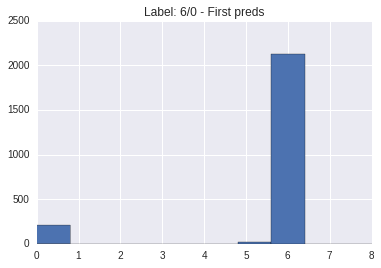

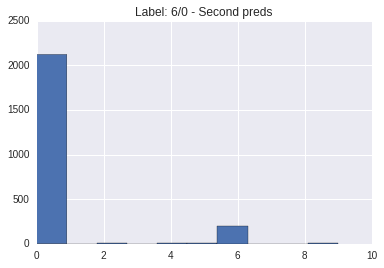

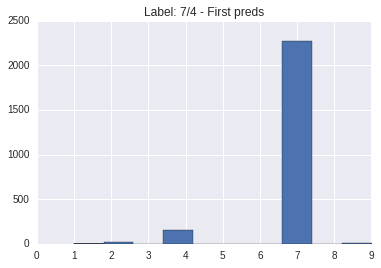

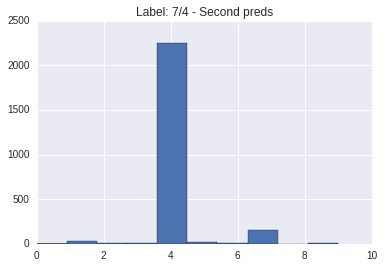

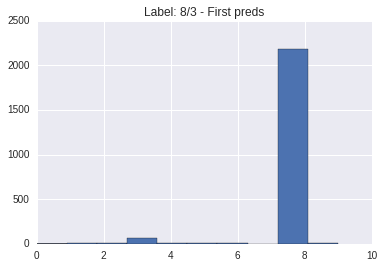

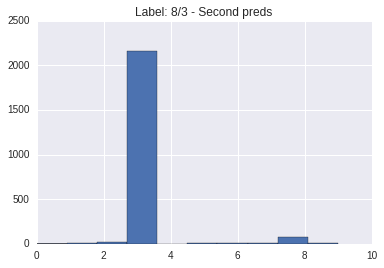

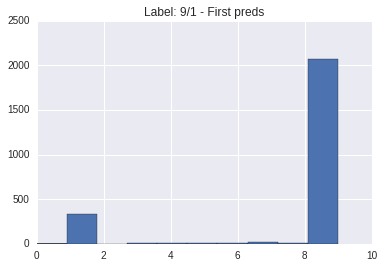

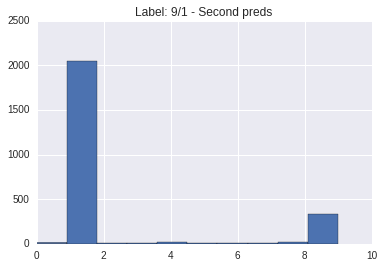

In [18]:
# Plot the prediction histograms for noisy labels

# scores contains the scores for our predictions
# org_label is the original label, noisy_label is the noisy label 
org_label, noisy_label = 8, 3

if FLAGS_VISUALIZE_PREDS:
    noisy_score_map = [[] for i in xrange(NUM_CLASSIFY)]
    for i in xrange(NUM_CLASSIFY): 
        noisy_score_map[i] = [[] for _ in range(NUM_CLASSIFY)]
            
    for i in xrange(labels_y.shape[0]):
        org, noise = int(labels_y[i]), int(noisy_y[i])
        if org != noise:
            noisy_score_map[org][noise].append(scores[i])
    
    # Visualize
    for i in xrange(len(noisy_beta_map)):
        for j in xrange(len(noisy_beta_map[i])):
            if len(noisy_beta_map[i][j]) > 500:
                # Get a list of all the scores for all the noisy data corresponding to i,j
                score_list = noisy_beta_map[i][j]
                first_preds, second_preds = [], []
                for k in xrange(len(noisy_beta_map[i][j])):
                    s = noisy_score_map[i][j][k]
                    s = s[:] # create a copy
                    first_preds.append(np.argmax(s))
                    s[np.argmax(s)] = -1
                    second_preds.append(np.argmax(s))
                plt.hist(first_preds)
                plt.title('Label: {}/{} - First preds'.format(i, j))
                plt.show()
                plt.hist(second_preds)
                plt.title('Label: {}/{} - Second preds'.format(i, j))
                plt.show()

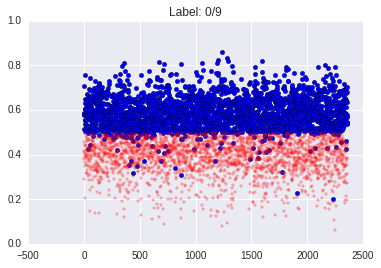

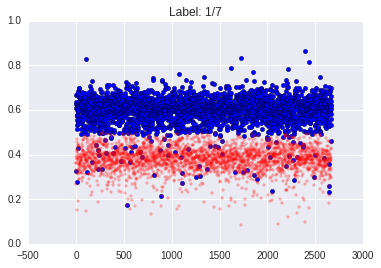

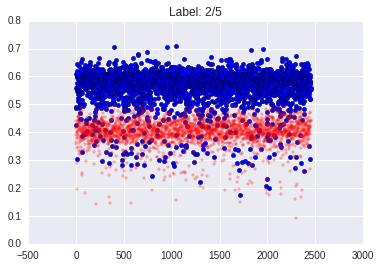

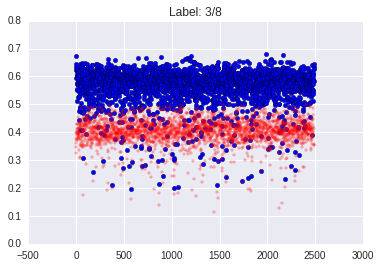

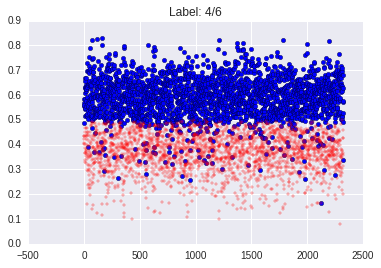

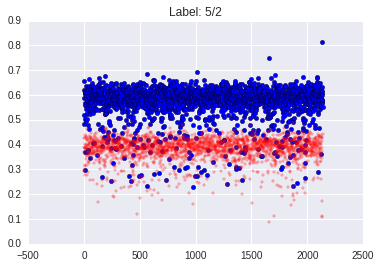

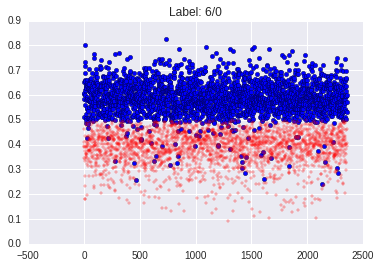

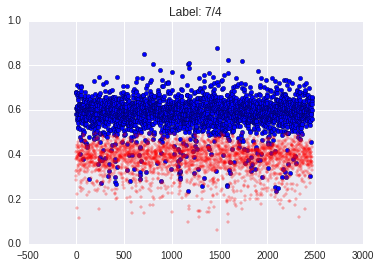

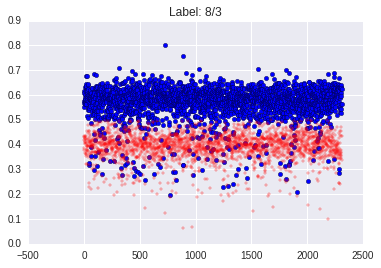

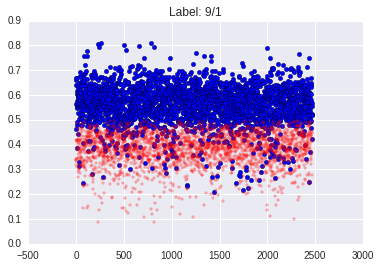

In [19]:
# Plot the prediction histograms for noisy labels

# scores contains the scores for our predictions
# org_label is the original label, noisy_label is the noisy label 

if FLAGS_VISUALIZE_PRED_PROB:
    noisy_score_map = [[] for i in xrange(NUM_CLASSIFY)]
    for i in xrange(NUM_CLASSIFY): 
        noisy_score_map[i] = [[] for _ in range(NUM_CLASSIFY)]
            
    for i in xrange(labels_y.shape[0]):
        org, noise = int(labels_y[i]), int(noisy_y[i])
        if org != noise:
            noisy_score_map[org][noise].append(scores[i])
    
    # Visualize
    for i in xrange(len(noisy_score_map)):
        for j in xrange(len(noisy_score_map[i])):
            if len(noisy_score_map[i][j]) > 500:
                # Get a list of all the scores for all the noisy data corresponding to i,j
                first_scores, second_scores = [], []
                for s in noisy_score_map[i][j]:
                    sorted_s = np.sort(s)[::-1]
                    first_scores.append(sorted_s[0])
                    second_scores.append(sorted_s[1])
                    
                plt.scatter(range(len(noisy_score_map[i][j])), first_scores)
                plt.scatter(range(len(noisy_score_map[i][j])), second_scores, color='r', marker='+')
                plt.title('Label: {}/{}'.format(i, j))
                plt.show()
                

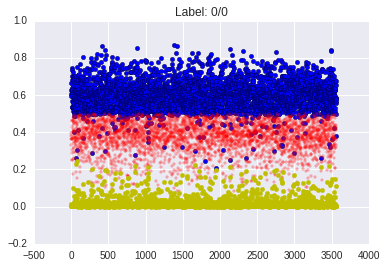

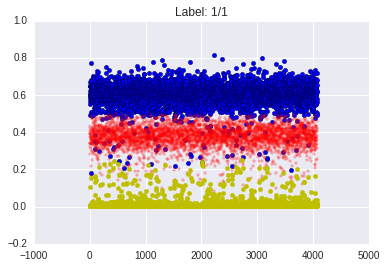

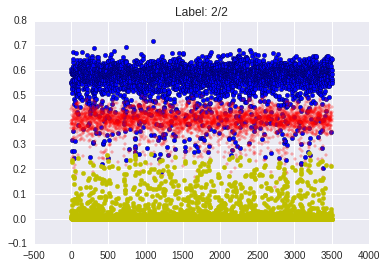

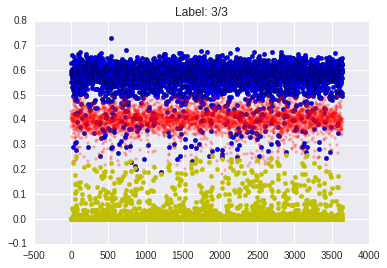

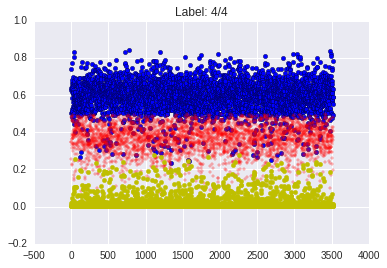

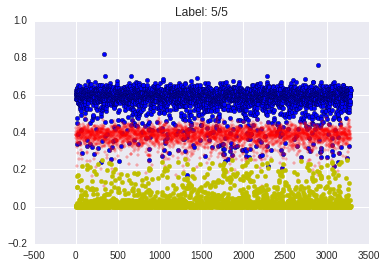

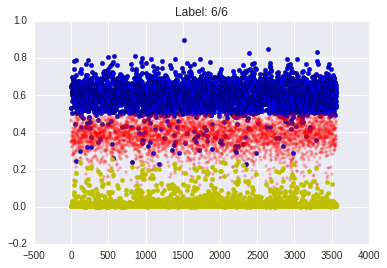

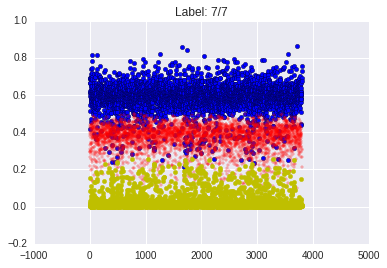

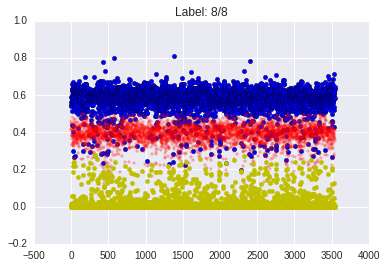

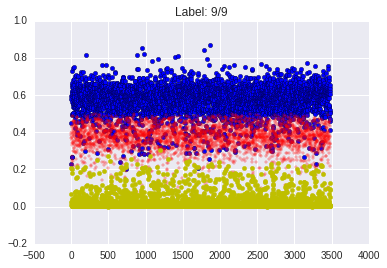

In [20]:
# Plot the prediction histograms for noisy labels

# scores contains the scores for our predictions
# org_label is the original label, noisy_label is the noisy label 

if FLAGS_VISUALIZE_PRED_PROB_NON_NOISY:
    score_map = [[] for i in xrange(NUM_CLASSIFY)]
    for i in xrange(NUM_CLASSIFY): 
        score_map[i] = [[] for _ in range(NUM_CLASSIFY)]
            
    for i in xrange(labels_y.shape[0]):
        org, noise = int(labels_y[i]), int(noisy_y[i])
        if org == noise:
            if i > len(scores):
                pdb.set_trace()
            score_map[org][noise].append(scores[i])
    
    # Visualize
    for i in xrange(len(score_map)):
        for j in xrange(len(score_map[i])):
            if len(score_map[i][j]) > 500:
                # Get a list of all the scores for all the noisy data corresponding to i,j
                first_scores, second_scores, third_scores = [], [], []
                for s in score_map[i][j]:
                    sorted_s = np.sort(s)[::-1]
                    first_scores.append(sorted_s[0])
                    second_scores.append(sorted_s[1])
                    third_scores.append(sorted_s[2])
                    
                plt.scatter(range(len(score_map[i][j])), first_scores)
                plt.scatter(range(len(score_map[i][j])), second_scores, color='r', marker='+')
                plt.scatter(range(len(score_map[i][j])), third_scores, color='y', marker='o')
                plt.title('Label: {}/{}'.format(i, j))
                plt.show()
                